In [32]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [33]:
def show_tensor_img(img_tensor,num_imgs=1,size=(1,28,28)):
    img_tensor=(img_tensor+1)/2
    img_unflat = img_tensor.detach().cpu()
    img_grid = make_grid(img_unflat[:num_imgs],nrow=5)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.show()


In [34]:
class Generator(nn.Module):
    def __init__(self, z_dim=10,im_chan=1,hidden_dim=64):
        super(Generator,self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.conv_block(z_dim,hidden_dim*4),
            self.conv_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
            self.conv_block(hidden_dim*2,hidden_dim),
            self.conv_block(hidden_dim,im_chan,kernel_size=4,final_layer=True)
        )

    def conv_block(self,input_ch,output_ch,kernel_size=3,stride=2,final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_ch,out_channels=output_ch,kernel_size=kernel_size,stride=stride),
                nn.BatchNorm2d(num_features=output_ch),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_ch,out_channels=output_ch,kernel_size=kernel_size,stride=stride),
                nn.Tanh()
            )
        
    def unsqueeze_noise(self,noise):
        return noise.view(len(noise),self.z_dim,1,1)
    
    def forward(self,noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [35]:
class Discriminator(nn.Module):
    def __init__(self,im_ch=1,hidden_dim=16):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            self.conv_block(im_ch,hidden_dim),
            self.conv_block(hidden_dim,hidden_dim*2),
            self.conv_block(hidden_dim*2,1,final_layer=True)
        )
        
    def conv_block(self,in_ch,out_ch,kernel_size=4,stride=2,final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=kernel_size,stride=stride),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(negative_slope=0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=kernel_size,stride=stride)
            )
    def forward(self,image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred),-1)
        

In [36]:
def get_noise(n_sample,z_dim,device='cpu'):
    return torch.randn(n_sample,z_dim,device=device)

In [37]:
gen = Generator()
disc = Discriminator()
print(gen)
print(gen.named_parameters())
print(disc)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(10, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)
<generator object Module.named_parameters at 0x7f28ec034ba0>
Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
      (1)

In [38]:
for name,param in gen.named_parameters():
    print(f"Layer: {name}, Shape: {param.shape}")
    print(f"Weights: {param.data}")
    print("------------------------")

Layer: gen.0.0.weight, Shape: torch.Size([10, 256, 3, 3])
Weights: tensor([[[[ 0.0019, -0.0084, -0.0146],
          [-0.0018,  0.0061,  0.0031],
          [-0.0205, -0.0133,  0.0107]],

         [[ 0.0193, -0.0051,  0.0132],
          [-0.0110, -0.0104, -0.0162],
          [-0.0044, -0.0201, -0.0156]],

         [[ 0.0186,  0.0076,  0.0034],
          [-0.0162, -0.0026, -0.0016],
          [-0.0029, -0.0071,  0.0158]],

         ...,

         [[ 0.0167, -0.0093, -0.0027],
          [ 0.0199,  0.0125, -0.0033],
          [ 0.0037, -0.0018,  0.0009]],

         [[ 0.0198,  0.0103, -0.0016],
          [-0.0174, -0.0043,  0.0045],
          [ 0.0194, -0.0064,  0.0033]],

         [[-0.0003, -0.0056, -0.0114],
          [-0.0157,  0.0078, -0.0106],
          [ 0.0077,  0.0070,  0.0047]]],


        [[[-0.0139,  0.0080,  0.0132],
          [ 0.0055, -0.0120, -0.0206],
          [ 0.0092,  0.0030, -0.0162]],

         [[ 0.0011, -0.0138,  0.0129],
          [-0.0110, -0.0139,  0.0179],
     

In [39]:
for name,param in disc.named_parameters():
    print(f"Layer: {name}, Shape: {param.shape}")
    print(f"Weights: {param.data}")
    print("------------------------")

Layer: disc.0.0.weight, Shape: torch.Size([16, 1, 4, 4])
Weights: tensor([[[[-0.0403,  0.0440, -0.0335, -0.1113],
          [ 0.0083,  0.1338,  0.1373, -0.2130],
          [-0.1689, -0.2096, -0.0192,  0.1718],
          [ 0.1190, -0.0886, -0.1593,  0.2088]]],


        [[[-0.0764, -0.1671,  0.0562, -0.0343],
          [-0.1469, -0.0002,  0.0489, -0.1772],
          [-0.0427, -0.0194, -0.2379, -0.1717],
          [ 0.0862,  0.0283, -0.1430,  0.2044]]],


        [[[-0.2150, -0.1366,  0.0973,  0.1678],
          [-0.0757,  0.1509,  0.0369, -0.1726],
          [ 0.0536,  0.0619,  0.0581,  0.0506],
          [-0.0970,  0.2196,  0.0881,  0.0030]]],


        [[[ 0.1918, -0.1116,  0.2268,  0.1138],
          [-0.0593, -0.1087, -0.1400, -0.1937],
          [ 0.0628, -0.1781,  0.0489, -0.2010],
          [ 0.0582, -0.2280, -0.1881, -0.0052]]],


        [[[-0.0212, -0.1425,  0.0697,  0.0083],
          [ 0.0377, -0.1528,  0.1925, -0.1450],
          [ 0.2151, -0.0091, -0.1832, -0.0175],
      

In [40]:
x = get_noise(1,10)
print(x)
print(gen.unsqueeze_noise(x))

tensor([[-1.1051, -0.9090, -0.2299, -1.1468,  0.2687,  1.1767,  1.4063,  1.0764,
          0.0237, -0.5532]])
tensor([[[[-1.1051]],

         [[-0.9090]],

         [[-0.2299]],

         [[-1.1468]],

         [[ 0.2687]],

         [[ 1.1767]],

         [[ 1.4063]],

         [[ 1.0764]],

         [[ 0.0237]],

         [[-0.5532]]]])


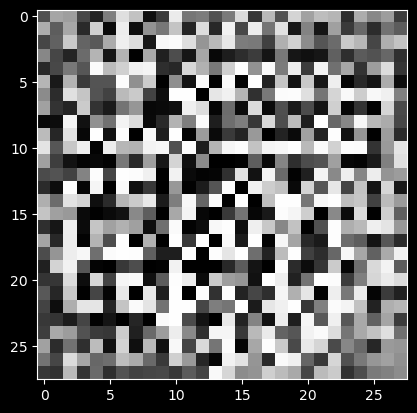

disc_output: tensor([[-0.3987]], grad_fn=<ViewBackward0>)


In [41]:
gen_img = gen.forward(x)
show_tensor_img(gen_img)
print("disc_output:",disc.forward(gen_img))

In [42]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

dataloader = DataLoader(
    MNIST('.',download=True,transform=transform),
    batch_size=batch_size,
    shuffle=True
)

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr = lr, betas=(beta_1,beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr, betas=(beta_1,beta_2))

def weight_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
    if isinstance(m,nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
        torch.nn.init.constant_(m.bias,0)

gen = gen.apply(weight_init)
disc = disc.apply(weight_init)

In [43]:
print(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)


In [44]:
n_epochs = 100
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
total_step = 0
for epoch in range(n_epochs):
    mean_discriminator_loss = 0
    mean_generator_loss = 0
    total_step = 0
    for real,_ in tqdm(dataloader):
        total_step += 1
        cur_batch_size = len(real)
        real = real.to(device)

        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size,z_dim,device=device)
        fake = gen(fake_noise)

        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))

        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))

        disc_loss = (disc_fake_loss+disc_real_loss)/2

        mean_discriminator_loss += disc_loss.item() / total_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()


        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size,z_dim,device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss=criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        mean_generator_loss += gen_loss.item() /total_step
        # if cur_step % display_step == 0 and cur_step > 0 :

        cur_step += 1

    checkpoint = {
        'epoch': epoch,
        'cur_step': cur_step,
        'gen_state_dict': gen.state_dict(),
        'gen_opt_state_dict': gen_opt.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'disc_opt_state_dict': disc_opt.state_dict(),
        'mean_generator_loss': mean_generator_loss,
        'mean_discriminator_loss': mean_discriminator_loss
    }
    
    torch.save(checkpoint, f'/mnt/d/ML_playground/Learn_GAN/when-I-learn-GAN/DCGAN/checkpoint/100checkpoint.pt')
    print(f'Epoch {epoch}, step {cur_step} Generator loss: {mean_generator_loss} Discriminator loss: {mean_discriminator_loss}')

100%|██████████| 469/469 [00:23<00:00, 19.76it/s]


Epoch 0, step 469 Generator loss: 4.383543118958562 Discriminator loss: 4.383543118958562


100%|██████████| 469/469 [00:22<00:00, 20.63it/s]


Epoch 1, step 938 Generator loss: 0.09898625717473535 Discriminator loss: 0.09898625717473535


100%|██████████| 469/469 [00:22<00:00, 20.51it/s]


Epoch 2, step 1407 Generator loss: 0.08206310236467561 Discriminator loss: 0.08206310236467561


100%|██████████| 469/469 [00:22<00:00, 20.86it/s]


Epoch 3, step 1876 Generator loss: 0.06921738009259669 Discriminator loss: 0.06921738009259669


100%|██████████| 469/469 [00:24<00:00, 19.20it/s]


Epoch 4, step 2345 Generator loss: 0.09950154853362489 Discriminator loss: 0.09950154853362489


100%|██████████| 469/469 [00:22<00:00, 20.61it/s]


Epoch 5, step 2814 Generator loss: 0.08732096699552087 Discriminator loss: 0.08732096699552087


100%|██████████| 469/469 [00:24<00:00, 19.50it/s]


Epoch 6, step 3283 Generator loss: 0.08221528835389333 Discriminator loss: 0.08221528835389333


100%|██████████| 469/469 [00:24<00:00, 19.33it/s]


Epoch 7, step 3752 Generator loss: 0.07752952700023565 Discriminator loss: 0.07752952700023565


100%|██████████| 469/469 [00:21<00:00, 21.59it/s]


Epoch 8, step 4221 Generator loss: 0.07013390142492605 Discriminator loss: 0.07013390142492605


100%|██████████| 469/469 [00:22<00:00, 20.42it/s]


Epoch 9, step 4690 Generator loss: 0.06438214159963096 Discriminator loss: 0.06438214159963096


100%|██████████| 469/469 [00:22<00:00, 21.09it/s]


Epoch 10, step 5159 Generator loss: 0.0584640362741128 Discriminator loss: 0.0584640362741128


100%|██████████| 469/469 [00:22<00:00, 20.78it/s]


Epoch 11, step 5628 Generator loss: 0.054353743731422814 Discriminator loss: 0.054353743731422814


100%|██████████| 469/469 [00:23<00:00, 19.60it/s]


Epoch 12, step 6097 Generator loss: 0.05054667331483995 Discriminator loss: 0.05054667331483995


100%|██████████| 469/469 [00:24<00:00, 18.94it/s]


Epoch 13, step 6566 Generator loss: 0.04784648552916521 Discriminator loss: 0.04784648552916521


100%|██████████| 469/469 [00:22<00:00, 20.62it/s]


Epoch 14, step 7035 Generator loss: 0.04517179241125421 Discriminator loss: 0.04517179241125421


100%|██████████| 469/469 [00:23<00:00, 19.82it/s]


Epoch 15, step 7504 Generator loss: 0.04290370041564896 Discriminator loss: 0.04290370041564896


100%|██████████| 469/469 [00:22<00:00, 21.23it/s]


Epoch 16, step 7973 Generator loss: 0.04064029024950757 Discriminator loss: 0.04064029024950757


100%|██████████| 469/469 [00:21<00:00, 21.35it/s]


Epoch 17, step 8442 Generator loss: 0.03833563067362579 Discriminator loss: 0.03833563067362579


100%|██████████| 469/469 [00:21<00:00, 21.84it/s]


Epoch 18, step 8911 Generator loss: 0.03660272320421051 Discriminator loss: 0.03660272320421051


100%|██████████| 469/469 [00:22<00:00, 21.18it/s]


Epoch 19, step 9380 Generator loss: 0.03495813647293418 Discriminator loss: 0.03495813647293418


100%|██████████| 469/469 [00:21<00:00, 21.47it/s]


Epoch 20, step 9849 Generator loss: 0.033369296087464966 Discriminator loss: 0.033369296087464966


100%|██████████| 469/469 [00:24<00:00, 19.01it/s]


Epoch 21, step 10318 Generator loss: 0.03191093241758302 Discriminator loss: 0.03191093241758302


100%|██████████| 469/469 [00:23<00:00, 19.89it/s]


Epoch 22, step 10787 Generator loss: 0.030607760082425522 Discriminator loss: 0.030607760082425522


100%|██████████| 469/469 [00:23<00:00, 20.21it/s]


Epoch 23, step 11256 Generator loss: 0.02945059323611537 Discriminator loss: 0.02945059323611537


100%|██████████| 469/469 [00:23<00:00, 20.22it/s]


Epoch 24, step 11725 Generator loss: 0.028197974455867615 Discriminator loss: 0.028197974455867615


100%|██████████| 469/469 [00:22<00:00, 20.82it/s]


Epoch 25, step 12194 Generator loss: 0.02712156379277424 Discriminator loss: 0.02712156379277424


100%|██████████| 469/469 [00:23<00:00, 20.25it/s]


Epoch 26, step 12663 Generator loss: 0.026158861256896402 Discriminator loss: 0.026158861256896402


100%|██████████| 469/469 [00:22<00:00, 21.01it/s]


Epoch 27, step 13132 Generator loss: 0.0253012620231022 Discriminator loss: 0.0253012620231022


100%|██████████| 469/469 [00:23<00:00, 20.31it/s]


Epoch 28, step 13601 Generator loss: 0.024451312320003436 Discriminator loss: 0.024451312320003436


100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


Epoch 29, step 14070 Generator loss: 0.023655811993664372 Discriminator loss: 0.023655811993664372


100%|██████████| 469/469 [00:24<00:00, 19.06it/s]


Epoch 30, step 14539 Generator loss: 0.022842644251320328 Discriminator loss: 0.022842644251320328


100%|██████████| 469/469 [00:21<00:00, 21.52it/s]


Epoch 31, step 15008 Generator loss: 0.022156207420078792 Discriminator loss: 0.022156207420078792


100%|██████████| 469/469 [00:23<00:00, 20.33it/s]


Epoch 32, step 15477 Generator loss: 0.021473313265146496 Discriminator loss: 0.021473313265146496


100%|██████████| 469/469 [00:24<00:00, 19.20it/s]


Epoch 33, step 15946 Generator loss: 0.020874942935726507 Discriminator loss: 0.020874942935726507


100%|██████████| 469/469 [00:22<00:00, 21.04it/s]


Epoch 34, step 16415 Generator loss: 0.02023639320009352 Discriminator loss: 0.02023639320009352


100%|██████████| 469/469 [00:21<00:00, 21.85it/s]


Epoch 35, step 16884 Generator loss: 0.019683366395321696 Discriminator loss: 0.019683366395321696


100%|██████████| 469/469 [00:22<00:00, 20.60it/s]


Epoch 36, step 17353 Generator loss: 0.019136063031424427 Discriminator loss: 0.019136063031424427


100%|██████████| 469/469 [00:23<00:00, 19.73it/s]


Epoch 37, step 17822 Generator loss: 0.018611210740043425 Discriminator loss: 0.018611210740043425


100%|██████████| 469/469 [00:21<00:00, 21.75it/s]


Epoch 38, step 18291 Generator loss: 0.018112022180282482 Discriminator loss: 0.018112022180282482


100%|██████████| 469/469 [00:21<00:00, 21.59it/s]


Epoch 39, step 18760 Generator loss: 0.01767550742535497 Discriminator loss: 0.01767550742535497


100%|██████████| 469/469 [00:21<00:00, 22.14it/s]


Epoch 40, step 19229 Generator loss: 0.01722014637750284 Discriminator loss: 0.01722014637750284


100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Epoch 41, step 19698 Generator loss: 0.016798152948155717 Discriminator loss: 0.016798152948155717


100%|██████████| 469/469 [00:22<00:00, 20.99it/s]


Epoch 42, step 20167 Generator loss: 0.01640733905089155 Discriminator loss: 0.01640733905089155


100%|██████████| 469/469 [00:23<00:00, 20.24it/s]


Epoch 43, step 20636 Generator loss: 0.016022398606793463 Discriminator loss: 0.016022398606793463


100%|██████████| 469/469 [00:22<00:00, 21.02it/s]


Epoch 44, step 21105 Generator loss: 0.015660525261964108 Discriminator loss: 0.015660525261964108


100%|██████████| 469/469 [00:21<00:00, 21.89it/s]


Epoch 45, step 21574 Generator loss: 0.015331873024010305 Discriminator loss: 0.015331873024010305


100%|██████████| 469/469 [00:22<00:00, 21.21it/s]


Epoch 46, step 22043 Generator loss: 0.015001658418236107 Discriminator loss: 0.015001658418236107


100%|██████████| 469/469 [00:22<00:00, 21.04it/s]


Epoch 47, step 22512 Generator loss: 0.014672047516304907 Discriminator loss: 0.014672047516304907


100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


Epoch 48, step 22981 Generator loss: 0.014375815461875299 Discriminator loss: 0.014375815461875299


100%|██████████| 469/469 [00:22<00:00, 20.88it/s]


Epoch 49, step 23450 Generator loss: 0.014077584795794412 Discriminator loss: 0.014077584795794412


100%|██████████| 469/469 [00:21<00:00, 21.45it/s]


Epoch 50, step 23919 Generator loss: 0.013832887935430358 Discriminator loss: 0.013832887935430358


100%|██████████| 469/469 [00:22<00:00, 20.44it/s]


Epoch 51, step 24388 Generator loss: 0.01352716260529797 Discriminator loss: 0.01352716260529797


100%|██████████| 469/469 [00:23<00:00, 20.28it/s]


Epoch 52, step 24857 Generator loss: 0.013263522277379945 Discriminator loss: 0.013263522277379945


100%|██████████| 469/469 [00:22<00:00, 20.99it/s]


Epoch 53, step 25326 Generator loss: 0.013019433866097269 Discriminator loss: 0.013019433866097269


100%|██████████| 469/469 [00:21<00:00, 21.37it/s]


Epoch 54, step 25795 Generator loss: 0.012780639303307036 Discriminator loss: 0.012780639303307036


100%|██████████| 469/469 [00:21<00:00, 21.96it/s]


Epoch 55, step 26264 Generator loss: 0.012544574109660927 Discriminator loss: 0.012544574109660927


100%|██████████| 469/469 [00:20<00:00, 22.78it/s]


Epoch 56, step 26733 Generator loss: 0.0123210532316798 Discriminator loss: 0.0123210532316798


100%|██████████| 469/469 [00:20<00:00, 22.61it/s]


Epoch 57, step 27202 Generator loss: 0.012108855667661714 Discriminator loss: 0.012108855667661714


100%|██████████| 469/469 [00:20<00:00, 22.76it/s]


Epoch 58, step 27671 Generator loss: 0.011895408037848287 Discriminator loss: 0.011895408037848287


100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


Epoch 59, step 28140 Generator loss: 0.01169550654374899 Discriminator loss: 0.01169550654374899


100%|██████████| 469/469 [00:23<00:00, 19.58it/s]


Epoch 60, step 28609 Generator loss: 0.01149552389732567 Discriminator loss: 0.01149552389732567


100%|██████████| 469/469 [00:21<00:00, 22.31it/s]


Epoch 61, step 29078 Generator loss: 0.011309278738165554 Discriminator loss: 0.011309278738165554


100%|██████████| 469/469 [00:19<00:00, 23.77it/s]


Epoch 62, step 29547 Generator loss: 0.011129600325702553 Discriminator loss: 0.011129600325702553


100%|██████████| 469/469 [00:19<00:00, 23.81it/s]


Epoch 63, step 30016 Generator loss: 0.010948483311631998 Discriminator loss: 0.010948483311631998


100%|██████████| 469/469 [00:20<00:00, 22.91it/s]


Epoch 64, step 30485 Generator loss: 0.010780097847178396 Discriminator loss: 0.010780097847178396


100%|██████████| 469/469 [00:21<00:00, 22.04it/s]


Epoch 65, step 30954 Generator loss: 0.010614926181680426 Discriminator loss: 0.010614926181680426


100%|██████████| 469/469 [00:19<00:00, 23.59it/s]


Epoch 66, step 31423 Generator loss: 0.01045373987593814 Discriminator loss: 0.01045373987593814


100%|██████████| 469/469 [00:19<00:00, 24.29it/s]


Epoch 67, step 31892 Generator loss: 0.010296957226626118 Discriminator loss: 0.010296957226626118


100%|██████████| 469/469 [00:19<00:00, 24.57it/s]


Epoch 68, step 32361 Generator loss: 0.010143461093724493 Discriminator loss: 0.010143461093724493


100%|██████████| 469/469 [00:20<00:00, 22.48it/s]


Epoch 69, step 32830 Generator loss: 0.009998491133786609 Discriminator loss: 0.009998491133786609


100%|██████████| 469/469 [00:20<00:00, 23.00it/s]


Epoch 70, step 33299 Generator loss: 0.009858616350385787 Discriminator loss: 0.009858616350385787


100%|██████████| 469/469 [00:21<00:00, 22.29it/s]


Epoch 71, step 33768 Generator loss: 0.009716097707507844 Discriminator loss: 0.009716097707507844


100%|██████████| 469/469 [00:18<00:00, 24.96it/s]


Epoch 72, step 34237 Generator loss: 0.00958188586480286 Discriminator loss: 0.00958188586480286


100%|██████████| 469/469 [00:18<00:00, 25.18it/s]


Epoch 73, step 34706 Generator loss: 0.00945082308684214 Discriminator loss: 0.00945082308684214


100%|██████████| 469/469 [00:18<00:00, 25.11it/s]


Epoch 74, step 35175 Generator loss: 0.00931975046185093 Discriminator loss: 0.00931975046185093


100%|██████████| 469/469 [00:18<00:00, 24.93it/s]


Epoch 75, step 35644 Generator loss: 0.009199401178146036 Discriminator loss: 0.009199401178146036


100%|██████████| 469/469 [00:18<00:00, 25.08it/s]


Epoch 76, step 36113 Generator loss: 0.009078404230739716 Discriminator loss: 0.009078404230739716


100%|██████████| 469/469 [00:18<00:00, 24.76it/s]


Epoch 77, step 36582 Generator loss: 0.008962081781450339 Discriminator loss: 0.008962081781450339


100%|██████████| 469/469 [00:18<00:00, 25.06it/s]


Epoch 78, step 37051 Generator loss: 0.00884449371612227 Discriminator loss: 0.00884449371612227


100%|██████████| 469/469 [00:18<00:00, 25.10it/s]


Epoch 79, step 37520 Generator loss: 0.00873449630713418 Discriminator loss: 0.00873449630713418


100%|██████████| 469/469 [00:21<00:00, 21.92it/s]


Epoch 80, step 37989 Generator loss: 0.008626684915225136 Discriminator loss: 0.008626684915225136


100%|██████████| 469/469 [00:24<00:00, 19.34it/s]


Epoch 81, step 38458 Generator loss: 0.008520609358136876 Discriminator loss: 0.008520609358136876


100%|██████████| 469/469 [00:21<00:00, 21.75it/s]


Epoch 82, step 38927 Generator loss: 0.008414768652545354 Discriminator loss: 0.008414768652545354


100%|██████████| 469/469 [00:20<00:00, 23.14it/s]


Epoch 83, step 39396 Generator loss: 0.00831470930805182 Discriminator loss: 0.00831470930805182


100%|██████████| 469/469 [00:21<00:00, 21.81it/s]


Epoch 84, step 39865 Generator loss: 0.008215348006317562 Discriminator loss: 0.008215348006317562


100%|██████████| 469/469 [00:23<00:00, 19.84it/s]


Epoch 85, step 40334 Generator loss: 0.008115880818192587 Discriminator loss: 0.008115880818192587


100%|██████████| 469/469 [00:23<00:00, 19.89it/s]


Epoch 86, step 40803 Generator loss: 0.008021794924451844 Discriminator loss: 0.008021794924451844


100%|██████████| 469/469 [00:21<00:00, 22.33it/s]


Epoch 87, step 41272 Generator loss: 0.007931115219446947 Discriminator loss: 0.007931115219446947


100%|██████████| 469/469 [00:20<00:00, 23.14it/s]


Epoch 88, step 41741 Generator loss: 0.007838082916227724 Discriminator loss: 0.007838082916227724


100%|██████████| 469/469 [00:19<00:00, 23.98it/s]


Epoch 89, step 42210 Generator loss: 0.007751863782291242 Discriminator loss: 0.007751863782291242


100%|██████████| 469/469 [00:19<00:00, 24.52it/s]


Epoch 90, step 42679 Generator loss: 0.007666475800322979 Discriminator loss: 0.007666475800322979


100%|██████████| 469/469 [00:20<00:00, 22.42it/s]


Epoch 91, step 43148 Generator loss: 0.007582643258249495 Discriminator loss: 0.007582643258249495


100%|██████████| 469/469 [00:20<00:00, 22.61it/s]


Epoch 92, step 43617 Generator loss: 0.007499640648915342 Discriminator loss: 0.007499640648915342


100%|██████████| 469/469 [00:23<00:00, 20.05it/s]


Epoch 93, step 44086 Generator loss: 0.007418847925289727 Discriminator loss: 0.007418847925289727


100%|██████████| 469/469 [00:20<00:00, 23.42it/s]


Epoch 94, step 44555 Generator loss: 0.007339554386691869 Discriminator loss: 0.007339554386691869


100%|██████████| 469/469 [00:20<00:00, 23.02it/s]


Epoch 95, step 45024 Generator loss: 0.0072629845883895455 Discriminator loss: 0.0072629845883895455


100%|██████████| 469/469 [00:19<00:00, 23.94it/s]


Epoch 96, step 45493 Generator loss: 0.007186432485500483 Discriminator loss: 0.007186432485500483


100%|██████████| 469/469 [00:19<00:00, 23.82it/s]


Epoch 97, step 45962 Generator loss: 0.007112908104922887 Discriminator loss: 0.007112908104922887


100%|██████████| 469/469 [00:19<00:00, 24.34it/s]


Epoch 98, step 46431 Generator loss: 0.007041036564313017 Discriminator loss: 0.007041036564313017


100%|██████████| 469/469 [00:18<00:00, 25.05it/s]


Epoch 99, step 46900 Generator loss: 0.006971463841887428 Discriminator loss: 0.006971463841887428


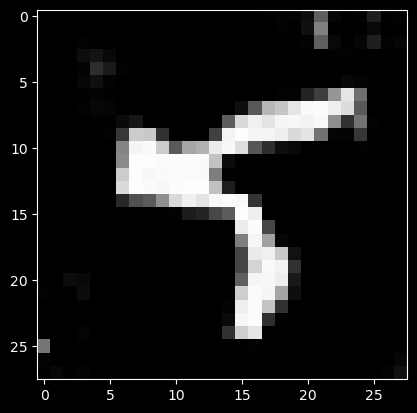

In [45]:
test_noise = get_noise(1,64,device='cuda')
test_gen = gen.forward(test_noise)
show_tensor_img(test_gen.detach(),num_imgs=1)


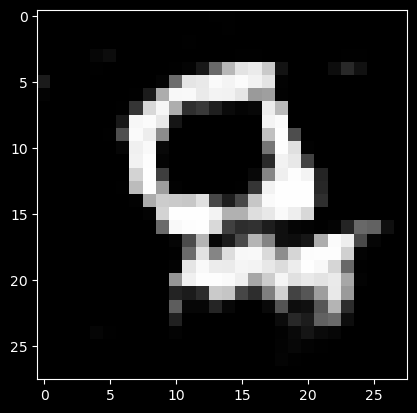

In [69]:
checkpoint = torch.load('/mnt/d/ML_playground/Learn_GAN/when-I-learn-GAN/DCGAN/checkpoint/checkpoint.pt')  # Load the checkpoint

criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# Load the generator and discriminator models
gen = Generator(z_dim).to(device)
gen.load_state_dict(checkpoint['gen_state_dict'])
disc = Discriminator().to(device)
disc.load_state_dict(checkpoint['disc_state_dict'])

# Load the optimizer states if necessary
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
gen_opt.load_state_dict(checkpoint['gen_opt_state_dict'])
disc_opt.load_state_dict(checkpoint['disc_opt_state_dict'])

# Load other necessary variables
epoch = checkpoint['epoch']
cur_step = checkpoint['cur_step']
mean_generator_loss = checkpoint['mean_generator_loss']
mean_discriminator_loss = checkpoint['mean_discriminator_loss']

test_noise = get_noise(1,64,device='cuda')
test_gen = gen.forward(test_noise)
show_tensor_img(test_gen.detach(),num_imgs=1)